# REINFORCE Tutorial

This tutorial is adapted from [pytorch script](https://github.com/JamesChuanggg/pytorch-REINFORCE/blob/master/reinforce_continuous.py). We will show how to use PyTorch to train a REINFORCE agent
on the Pendulum-v0 task from the `OpenAI Gym <https://gym.openai.com/>`__.

**Task**

The inverted pendulum swingup problem is a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright. You can find an
official leaderboard with various algorithms and visualizations at the
[Gym website](https://gym.openai.com/envs/Pendulum-v0).

<img src="https://user-images.githubusercontent.com/8510097/31701471-726f54c0-b385-11e7-9f05-5c50f2affbb4.PNG" alt="Pendulum" style="width: 400px;"/>

This is a continuous control task where the action is a continuous variable of the joint effort.The reward is cost funtion of the observation, and the lowest cost is -16.2736044, while the highest loss is 0. So the reward is always negative.  In essence, the goal is maximize the reward, to remain at zero angle (vertical), with the least rotational velocity, and the least effort. More detail in this [website](https://github.com/openai/gym/wiki/Pendulum-v0)

**Algorithm**

We will implement the most basic policy gradient algorithm

<img src="https://i.stack.imgur.com/c9eKs.png" alt="REINFORCE algorithm" style="width: 600px;"/>

In [1]:
%matplotlib inline

In [2]:
import sys
import math
import gym
import numpy as np

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils as utils
import torchvision.transforms as T
from torch.autograd import Variable

In [3]:
class NormalizedActions(gym.ActionWrapper):

    def _action(self, action):
        action = (action + 1) / 2  # [-1, 1] => [0, 1]
        action *= (self.action_space.high - self.action_space.low)
        action += self.action_space.low
        return action

    def _reverse_action(self, action):
        action -= self.action_space.low
        action /= (self.action_space.high - self.action_space.low)
        action = action * 2 - 1
        return actions

**Policy**

For the continuous control task, the input into the policy is the state observation, and we assume the policy $\pi(a|s)$ follows the Gaussian distribution $N(\mu(s), \sigma(s))$. After getting the Gaussian distribution parameter from the policy network, action can be sampled from the Gaussian distribution.


In [4]:
class Policy(nn.Module):
    def __init__(self, hidden_size, num_inputs, action_space):
        super(Policy, self).__init__()
        self.action_space = action_space
        num_outputs = action_space.shape[0]

        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, num_outputs)
        self.linear2_ = nn.Linear(hidden_size, num_outputs)

    def forward(self, inputs):
        x = inputs
        x = F.relu(self.linear1(x))
        mu = self.linear2(x)
        sigma_sq = self.linear2_(x)

        return mu, sigma_sq

**Loss in REINFORCE algorithm**

According to the pseudo code, for each episode, we want to maximize the $\sum_{t=1}^T (\log \pi(a_t|s_t) v_t) = \sum_{t=1}^T (\log \pi(a_t|s_t) (\sum_{k=t+1}^{T} \gamma^{k-t-1}r_k))$. Then the loss can be defined calculated as $-\sum_{t=1}^T (\log \pi(a_t|s_t) (\sum_{k=t+1}^{T} \gamma^{k-t-1}r_k))$. In this implementation, we do not consider the variance reduction tricks.

In [5]:
class REINFORCE:
    def __init__(self, hidden_size, num_inputs, action_space, device):
        self.action_space = action_space
        self.model = Policy(hidden_size, num_inputs, action_space)
        self.model = self.model.to(device)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        self.device = device

    def normal(self, x, mu, sigma_sq):
        pi = Variable(torch.FloatTensor([math.pi])).to(self.device)
        a = (-1*(Variable(x)-mu).pow(2)/(2*sigma_sq)).exp()
        b = 1/(2*sigma_sq*pi.expand_as(sigma_sq)).sqrt()
        return a*b

    def select_action(self, state):
        mu, sigma_sq = self.model(Variable(state).to(self.device))
        #softplus is smooth approximation of RELU to constrain the output to be positive
        sigma_sq = F.softplus(sigma_sq) 

        eps = torch.randn(mu.size())
        # calculate the probability
        action = mu + sigma_sq.sqrt()*Variable(eps)
        action = action.to(device).data
        prob = self.normal(action, mu, sigma_sq)
        pi = Variable(torch.FloatTensor([math.pi])).to(self.device)
        entropy = -0.5*((sigma_sq+2*pi.expand_as(sigma_sq)).log()+1)

        log_prob = prob.log()
        return action, log_prob, entropy

    def update_parameters(self, rewards, log_probs, entropies, gamma):
        R = torch.zeros(1)
        loss = 0
        ## TODO: calculate the loss 
        for i in reversed(range(len(rewards))):
            
            
            # The entropy loss is to constrain the entropy of the Gaussian distribution
            # to be relatively high. The higher entropy of the Gaussian distribution,
            # the more exploration
            loss = loss - 0.0001*entropies[i].to(self.device)
        loss = loss / len(rewards)
        
        self.optimizer.zero_grad()
        loss.backward()
        utils.clip_grad_norm(self.model.parameters(), 40)
        self.optimizer.step()


**Pipeline of REINFORCE algorithm**

According to the pseudo code, we will interact with the environment based on the action from policy network, and collect the episode information to update the policy network.

/Users/guoyijie/miniconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
/Users/guoyijie/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: <class '__main__.NormalizedActions'> doesn't implement 'action' method. Maybe it implements deprecated '_action' method.
Episode: 0, reward: -1535.8656212975982
Episode: 1, reward: -1206.3985682469533
Episode: 2, reward: -1362.7517803242752
Episode: 3, reward: -1448.3654630507817
Episode: 4, reward: -1430.98533258673
Episode: 5, reward: -1334.7092195244277
Episode: 6, reward: -1709.6790353082847
Episode: 7, reward: -1588.7193453733016
Episode: 8, reward: -1280.0936525507984
Episode: 9, reward: -1384.5759223724572
Episode: 10, reward: -1512.357595171195
Episode: 11, reward: -1517.2302542900657
Episode: 12, reward: -1461.571827246852
Episode: 13, reward: -1528.73837588411
Episode: 14, reward: -1538.260536053967
Episode: 15, reward: -1452.186117061105
Episode: 16, reward: -1381.4083612532

Episode: 191, reward: -1642.1860143841643
Episode: 192, reward: -1641.5651783523
Episode: 193, reward: -1429.0208405090048
Episode: 194, reward: -1358.6343324784339
Episode: 195, reward: -1465.8624772258422
Episode: 196, reward: -1644.5863070973573
Episode: 197, reward: -1388.8745557468496
Episode: 198, reward: -1636.2726715245299
Episode: 199, reward: -1625.2290544684458
Episode: 200, reward: -1497.6376008537568
Episode: 201, reward: -1459.1340275757912
Episode: 202, reward: -1426.5926941179575
Episode: 203, reward: -1618.4458328566002
Episode: 204, reward: -1619.6807783908955
Episode: 205, reward: -1423.1189021400496
Episode: 206, reward: -1508.5432202356603
Episode: 207, reward: -1644.9488744642604
Episode: 208, reward: -1462.9093930406798
Episode: 209, reward: -1452.297340340975
Episode: 210, reward: -1398.1260336918292
Episode: 211, reward: -1572.4617726562365
Episode: 212, reward: -1509.1764774585563
Episode: 213, reward: -1483.6181096173607
Episode: 214, reward: -1579.6181009204

Episode: 389, reward: -1642.954486599756
Episode: 390, reward: -1591.520890998081
Episode: 391, reward: -1558.1318637107152
Episode: 392, reward: -1587.8658376091626
Episode: 393, reward: -1510.452688592928
Episode: 394, reward: -1530.066291292861
Episode: 395, reward: -1563.671924132125
Episode: 396, reward: -1498.6033845898694
Episode: 397, reward: -1529.3484009500785
Episode: 398, reward: -1542.3475596787557
Episode: 399, reward: -1536.8231738221218
Episode: 400, reward: -1558.2590987202013
Episode: 401, reward: -1575.8977476872633
Episode: 402, reward: -1520.393062751149
Episode: 403, reward: -1544.2852699787231
Episode: 404, reward: -1590.2824099153695
Episode: 405, reward: -1478.7210019068884
Episode: 406, reward: -1471.688949152975
Episode: 407, reward: -1503.593965518567
Episode: 408, reward: -1491.5262914875673
Episode: 409, reward: -1579.7085760987034
Episode: 410, reward: -1518.277055652407
Episode: 411, reward: -1544.9551581267797
Episode: 412, reward: -1610.2816813526047
E

Episode: 586, reward: -1439.2876525466872
Episode: 587, reward: -1408.1368961670457
Episode: 588, reward: -1435.9733414988268
Episode: 589, reward: -1562.4180328891257
Episode: 590, reward: -1455.2604938245267
Episode: 591, reward: -1444.1259488105636
Episode: 592, reward: -1494.1357220615896
Episode: 593, reward: -1478.8676632080621
Episode: 594, reward: -1470.914715344054
Episode: 595, reward: -1506.5183827938401
Episode: 596, reward: -1525.3471397929666
Episode: 597, reward: -1521.0533821025858
Episode: 598, reward: -1505.2063889219407
Episode: 599, reward: -1472.3643079499534
Episode: 600, reward: -1495.9513151402905
Episode: 601, reward: -1342.6714480289231
Episode: 602, reward: -1370.8845476008755
Episode: 603, reward: -1327.2723107731467
Episode: 604, reward: -1496.970439613091
Episode: 605, reward: -1344.7137949852395
Episode: 606, reward: -1466.6537182768773
Episode: 607, reward: -1524.9100436216104
Episode: 608, reward: -1472.0085698223188
Episode: 609, reward: -1367.34999426

Episode: 784, reward: -1323.6015852596981
Episode: 785, reward: -1470.4741097682086
Episode: 786, reward: -1303.0137929407101
Episode: 787, reward: -1283.6981344516116
Episode: 788, reward: -1365.2871819711424
Episode: 789, reward: -1363.4982943522991
Episode: 790, reward: -1314.729863690426
Episode: 791, reward: -1245.8347892438742
Episode: 792, reward: -1260.7989479440052
Episode: 793, reward: -1190.7727663683927
Episode: 794, reward: -1425.9749316789732
Episode: 795, reward: -1265.6976521727574
Episode: 796, reward: -1364.1209408784143
Episode: 797, reward: -1406.6722434752858
Episode: 798, reward: -1341.7308538795257
Episode: 799, reward: -1396.0791939497287
Episode: 800, reward: -1179.3631468787344
Episode: 801, reward: -1333.3749649589658
Episode: 802, reward: -1371.1464409221312
Episode: 803, reward: -1379.2640600083437
Episode: 804, reward: -1133.8495049711744
Episode: 805, reward: -1357.678304962059
Episode: 806, reward: -1211.1206664220256
Episode: 807, reward: -1335.90621745

Episode: 982, reward: -1672.9487821868363
Episode: 983, reward: -1318.375271938723
Episode: 984, reward: -1507.1768041124756
Episode: 985, reward: -1209.865333189122
Episode: 986, reward: -1336.79145210372
Episode: 987, reward: -1520.4971847554293
Episode: 988, reward: -1433.3826463261312
Episode: 989, reward: -1189.3611183375917
Episode: 990, reward: -1191.5736858573305
Episode: 991, reward: -1099.3273156588675
Episode: 992, reward: -1218.9538374400722
Episode: 993, reward: -1235.5541432880382
Episode: 994, reward: -1111.903141967548
Episode: 995, reward: -1244.0442162252236
Episode: 996, reward: -1585.9446811493203
Episode: 997, reward: -1057.5783804449911
Episode: 998, reward: -1161.124232549534
Episode: 999, reward: -1155.0889326315782
Episode: 1000, reward: -1077.353847106734
Episode: 1001, reward: -1216.7102351853123
Episode: 1002, reward: -1372.6184915126069
Episode: 1003, reward: -1073.6178660371543
Episode: 1004, reward: -1138.9677744451883
Episode: 1005, reward: -1523.4555246

Episode: 1176, reward: -900.7000159650956
Episode: 1177, reward: -1210.4684550149177
Episode: 1178, reward: -1253.040450887193
Episode: 1179, reward: -834.5904491532943
Episode: 1180, reward: -1107.0976031028413
Episode: 1181, reward: -1355.8154735172361
Episode: 1182, reward: -1324.389253336284
Episode: 1183, reward: -1062.3705847253918
Episode: 1184, reward: -1229.3262633787415
Episode: 1185, reward: -1186.4131264060588
Episode: 1186, reward: -1308.7777211158905
Episode: 1187, reward: -1251.8929801877803
Episode: 1188, reward: -1273.3108563221676
Episode: 1189, reward: -932.174399898577
Episode: 1190, reward: -1249.4614533215827
Episode: 1191, reward: -1248.2349846658947
Episode: 1192, reward: -1308.160920516073
Episode: 1193, reward: -1284.1807960646784
Episode: 1194, reward: -1194.8541778189278
Episode: 1195, reward: -1200.3370195522043
Episode: 1196, reward: -1147.4167768906984
Episode: 1197, reward: -1322.692310120452
Episode: 1198, reward: -1268.2130023017894
Episode: 1199, rewa

Episode: 1369, reward: -1202.3142739337318
Episode: 1370, reward: -1071.9317701907216
Episode: 1371, reward: -1194.0848955132633
Episode: 1372, reward: -1404.2288828316691
Episode: 1373, reward: -1112.9231682215345
Episode: 1374, reward: -1271.0880365872235
Episode: 1375, reward: -1216.1464063637375
Episode: 1376, reward: -1214.2271939017332
Episode: 1377, reward: -1334.5305328357538
Episode: 1378, reward: -1169.0806865764644
Episode: 1379, reward: -1212.586428246001
Episode: 1380, reward: -1029.8869301475108
Episode: 1381, reward: -1001.0989245280402
Episode: 1382, reward: -1328.6901198638607
Episode: 1383, reward: -1325.8968018615271
Episode: 1384, reward: -1187.6705963584966
Episode: 1385, reward: -1296.8871904818925
Episode: 1386, reward: -1324.8751096632923
Episode: 1387, reward: -1378.6710968964333
Episode: 1388, reward: -1246.7657676787567
Episode: 1389, reward: -1067.3961673776407
Episode: 1390, reward: -1273.3422687953782
Episode: 1391, reward: -1357.0167188962516
Episode: 139

Episode: 1563, reward: -1362.7659774157164
Episode: 1564, reward: -1168.015861711396
Episode: 1565, reward: -1107.421380189349
Episode: 1566, reward: -1299.5431608259644
Episode: 1567, reward: -1292.7181283577672
Episode: 1568, reward: -1115.6396149708098
Episode: 1569, reward: -1328.8387360704073
Episode: 1570, reward: -1113.4333901937903
Episode: 1571, reward: -1203.0540781260684
Episode: 1572, reward: -1183.7459175861509
Episode: 1573, reward: -1066.9935437582817
Episode: 1574, reward: -1059.3371843586833
Episode: 1575, reward: -1054.103415862473
Episode: 1576, reward: -1116.6329523710315
Episode: 1577, reward: -872.5708516332159
Episode: 1578, reward: -1325.7830200299159
Episode: 1579, reward: -1206.2964288890184
Episode: 1580, reward: -1167.635302617356
Episode: 1581, reward: -1012.5134928467882
Episode: 1582, reward: -1194.872309736698
Episode: 1583, reward: -1175.4361411979457
Episode: 1584, reward: -1032.7268130821255
Episode: 1585, reward: -1208.6428719375422
Episode: 1586, re

Episode: 1756, reward: -1080.3345121331556
Episode: 1757, reward: -1150.8601379761233
Episode: 1758, reward: -1015.055953518572
Episode: 1759, reward: -1042.7670882334514
Episode: 1760, reward: -1036.3737818763937
Episode: 1761, reward: -1002.9366525142116
Episode: 1762, reward: -1348.0275415293402
Episode: 1763, reward: -1255.2149226132192
Episode: 1764, reward: -1232.0732940334024
Episode: 1765, reward: -1182.94086295111
Episode: 1766, reward: -1267.637528697543
Episode: 1767, reward: -1128.902124524176
Episode: 1768, reward: -1308.4830013840256
Episode: 1769, reward: -1263.7391565512949
Episode: 1770, reward: -996.8065160131677
Episode: 1771, reward: -1243.0028526602014
Episode: 1772, reward: -1176.696276520746
Episode: 1773, reward: -1039.7586493017664
Episode: 1774, reward: -1266.4206427534543
Episode: 1775, reward: -1156.2742573822554
Episode: 1776, reward: -1353.2957650052117
Episode: 1777, reward: -1261.3637491938857
Episode: 1778, reward: -1036.4579982707974
Episode: 1779, rew

Episode: 1950, reward: -992.5531863744243
Episode: 1951, reward: -1240.3364602381048
Episode: 1952, reward: -1255.8861981681212
Episode: 1953, reward: -1077.8477236796364
Episode: 1954, reward: -998.7428640020478
Episode: 1955, reward: -1127.329703715139
Episode: 1956, reward: -1132.7644748839086
Episode: 1957, reward: -1001.1743622859503
Episode: 1958, reward: -915.0453907157724
Episode: 1959, reward: -890.412251832937
Episode: 1960, reward: -954.2469614149932
Episode: 1961, reward: -1009.3677262159384
Episode: 1962, reward: -1131.0607917779907
Episode: 1963, reward: -1207.4908478733175
Episode: 1964, reward: -950.3445922564467
Episode: 1965, reward: -849.6693425793082
Episode: 1966, reward: -896.6607367581739
Episode: 1967, reward: -893.2791171483246
Episode: 1968, reward: -1067.999953193812
Episode: 1969, reward: -998.6903645243339
Episode: 1970, reward: -878.0826173109774
Episode: 1971, reward: -1383.2693318761658
Episode: 1972, reward: -1125.2500850779597
Episode: 1973, reward: -1

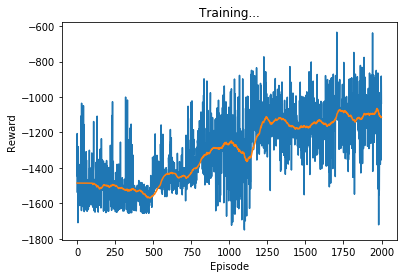

In [6]:
env = gym.make('Pendulum-v0')
env = NormalizedActions(env)
env.seed(498)
torch.manual_seed(498)
np.random.seed(498)

device = torch.device('cpu')
agent = REINFORCE(hidden_size=128, num_inputs=env.observation_space.shape[0], action_space=env.action_space, device=device)
reward_list = []
for i_episode in range(2000):
    state = torch.Tensor([env.reset()])
    entropies = []
    log_probs = []
    rewards = []
    for t in range(1000):
        ## TODO: given the state, get the action from the policy network,
        ## take the action in the environment, put the entropy,log probability
        ## and reward value into the corresponding list, update the state
        
        
        
        if done:
            break
    agent.update_parameters(rewards, log_probs, entropies, gamma=0.99)
    reward_list.append(np.sum(rewards))
    print("Episode: {}, reward: {}".format(i_episode, np.sum(rewards)))
    
env.close()

import matplotlib.pyplot as plt
reward_list = torch.FloatTensor(reward_list)
plt.figure(2)
plt.plot(reward_list.numpy())
plt.title('Training...')
plt.xlabel('Episode')
plt.ylabel('Reward')
if len(reward_list) >= 100:
    means = reward_list.unfold(0, 100, 1).mean(1).view(-1)
    means = torch.cat((torch.ones(99)*means[0], means))
    plt.plot(means.numpy())
plt.show()